[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/028_pytorch_nn/pytorch_nn.ipynb)

# Pytorch - Redes Neuronales

Se esta usando un dataset basado en 22470 grafos de Facebook que contiene 4 clases de tipos de páginas (tvshow,goverment,company y politician) que estan conectadas entre si y uso las siguientes librerias para la aplicacion del entrenamiento con redes neuronales.

In [2]:
import torch
import numpy as np
import torch.nn as nn
import networkx as nx
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

## Preprocesamiento y Normalización

Estamos leyendo el dataset donde tenemos las conexiones y el otro donde tenemos las etiquetas para posteriormente usar la libreria de networks que nos permite trabajar con grafos, consecuentemente extraemos las caracteristicas de los grafos y los normalizamos con la funcion de la libreria sklearn.preprocessing "StandardScaler" la cual esta designada para normalizar los grafos para dar una relacion entre las caracteristicas del modelo.

In [3]:
# Cargar conexiones
edges = pd.read_csv('musae_facebook_edges.csv')

# Cargar etiquetas
targets = pd.read_csv('musae_facebook_target.csv')

# 2. Crear grafo
G = nx.from_pandas_edgelist(edges, 'id_1', 'id_2')

# 3. Extraer características para cada nodo
features = []
node_ids = []

for node in G.nodes():
    # Extraer características básicas del grafo
    if int(node) in targets['id'].values:  # Verificar que el nodo tenga etiqueta
        degree = G.degree(node)
        try:
            clustering = nx.clustering(G, node)
        except:
            clustering = 0
        # Puedes agregar más características según necesites
        
        features.append([degree, clustering])
        node_ids.append(int(node))

# Convertir a DataFrame para facilitar el manejo
features_df = pd.DataFrame(features, columns=['degree', 'clustering'])
features_df['id'] = node_ids

# 4. Unir características con etiquetas
data = pd.merge(features_df, targets, on='id')

# 5. Preparar datos para el modelo
X = data[['degree', 'clustering']]  # Características
y = data['page_type']  # Etiquetas de categoría

# Codificar las etiquetas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalizar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(X.shape)

# Conteo de páginas por categoría
print("\nDistribución de categorías:")
print(y.value_counts())

(22470, 2)

Distribución de categorías:
page_type
government    6880
company       6495
politician    5768
tvshow        3327
Name: count, dtype: int64


## Division

Dividi el modelo en datos de prueba y entrenamiento

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)
print("\nTamaño de los conjuntos de datos:")
print(f"Entrenamiento: {X_train.shape}, Prueba: {X_test.shape}")


Tamaño de los conjuntos de datos:
Entrenamiento: (17976, 2), Prueba: (4494, 2)


## Implementación y Entrenamiento

Aqui implementamos el Modulo nn de Pytorch que nos permite trabajar con una clase heredada de torch.nn.module la cual nos permite construir la arquitectura del modelo y en base a esa arquitectura se empieza el entrenamiento designando los hiperparametros y hallando las precisiones de los datos de prueba y de entrenamiento.

In [24]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# creamos una clase que hereda de `torch.nn.Module`

class Facebook(nn.Module):
    # constructor
    def __init__(self, D_in, H1, D_out):
        # llamamos al constructor de la clase madre
        super(Facebook, self).__init__()

        # definimos nuestra única capa oculta
        self.fc1 = nn.Linear(D_in, H1)
        self.relu1 = nn.ReLU()
        
        # Capa final
        self.fc2 = nn.Linear(H1, D_out)

    # lógica para calcular las salidas de la red
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        
        x = self.fc2(x)
        return x

# Inicializar el modelo
D_in = X_train.shape[1]  # Número de características
H1 = 8  # Número de neuronas en la capa oculta
D_out = len(label_encoder.classes_)  # Número de categorías

model = Facebook(D_in, H1, D_out)
if torch.cuda.is_available():
    model = model.cuda()
    X_train_tensor = X_train_tensor.cuda()
    y_train_tensor = y_train_tensor.cuda()
    X_test_tensor = X_test_tensor.cuda()
    
    # Configurar función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# Inicializar listas para almacenar métricas
test_losses = []
train_accuracies = []
test_accuracies = []
epochs_list = []

def evaluate(x):
    model.eval()  # Poner el modelo en modo evaluación
    with torch.no_grad():  # Desactivar cálculo de gradientes para evaluación
        y_pred = model(x)
        y_probas = torch.softmax(y_pred, dim=1)
        return torch.argmax(y_probas, dim=1)

# Entrenamiento
epochs = 1000
log_each = 10
l = []
model.train()

for e in range(1, epochs+1):

    # forward
    y_pred = model(X_train_tensor)

    # loss
    loss = criterion(y_pred, y_train_tensor)
    l.append(loss.item())

    # Calcular precisión de entrenamiento
    with torch.no_grad():
        train_pred = torch.argmax(y_pred, dim=1)
        train_acc = (train_pred == y_train_tensor).float().mean().item()
        train_accuracies.append(train_acc)

    # ponemos a cero los gradientes
    optimizer.zero_grad()

    # Backprop (calculamos todos los gradientes automáticamente)
    loss.backward()

    # update de los pesos
    optimizer.step()

    if not e % log_each:

        # Guardar la época para gráficas
        epochs_list.append(e)

        model.eval()  # Cambiar a modo evaluación
        with torch.no_grad():
                test_outputs = model(X_test_tensor)
                test_loss = criterion(test_outputs, torch.tensor(y_test, device='cuda' if torch.cuda.is_available() else 'cpu'))
                test_losses.append(test_loss.item())
                
                test_pred = torch.argmax(test_outputs, dim=1)
                test_acc = (test_pred.cpu() == torch.tensor(y_test)).float().mean().item()
                test_accuracies.append(test_acc)
                model.train()  # Volver a modo entrenamiento

        print(f"Epoch {e}/{epochs} Train Loss: {np.mean(l[-log_each:]):.5f} Test Loss: {test_loss.item():.5f} Train Acc: {train_acc:.4f} Test Acc: {test_acc:.4f}")


     
y_pred = evaluate(X_test_tensor)
accuracy = accuracy_score(y_test, y_pred.cpu().numpy())

print(f"Precisión del modelo: {accuracy * 100:.2f}%")

Epoch 10/1000 Train Loss: 1.38044 Test Loss: 1.32811 Train Acc: 0.3662 Test Acc: 0.3830
Epoch 20/1000 Train Loss: 1.30239 Test Loss: 1.27626 Train Acc: 0.4270 Test Acc: 0.4263
Epoch 30/1000 Train Loss: 1.27215 Test Loss: 1.26734 Train Acc: 0.4276 Test Acc: 0.4275
Epoch 40/1000 Train Loss: 1.26397 Test Loss: 1.25868 Train Acc: 0.4332 Test Acc: 0.4339
Epoch 50/1000 Train Loss: 1.25859 Test Loss: 1.25520 Train Acc: 0.4332 Test Acc: 0.4364
Epoch 60/1000 Train Loss: 1.25560 Test Loss: 1.25162 Train Acc: 0.4344 Test Acc: 0.4335
Epoch 70/1000 Train Loss: 1.25268 Test Loss: 1.24878 Train Acc: 0.4354 Test Acc: 0.4364
Epoch 80/1000 Train Loss: 1.25019 Test Loss: 1.24607 Train Acc: 0.4361 Test Acc: 0.4364
Epoch 90/1000 Train Loss: 1.24795 Test Loss: 1.24357 Train Acc: 0.4351 Test Acc: 0.4364
Epoch 100/1000 Train Loss: 1.24591 Test Loss: 1.24135 Train Acc: 0.4374 Test Acc: 0.4410
Epoch 110/1000 Train Loss: 1.24400 Test Loss: 1.23932 Train Acc: 0.4372 Test Acc: 0.4415
Epoch 120/1000 Train Loss: 1.2

## Gráficas

Usamos la libreria de matplotlib para poder graficar e interpretar los valores de la funcion de costo y la precision de los datos de prueba y entrenamiento

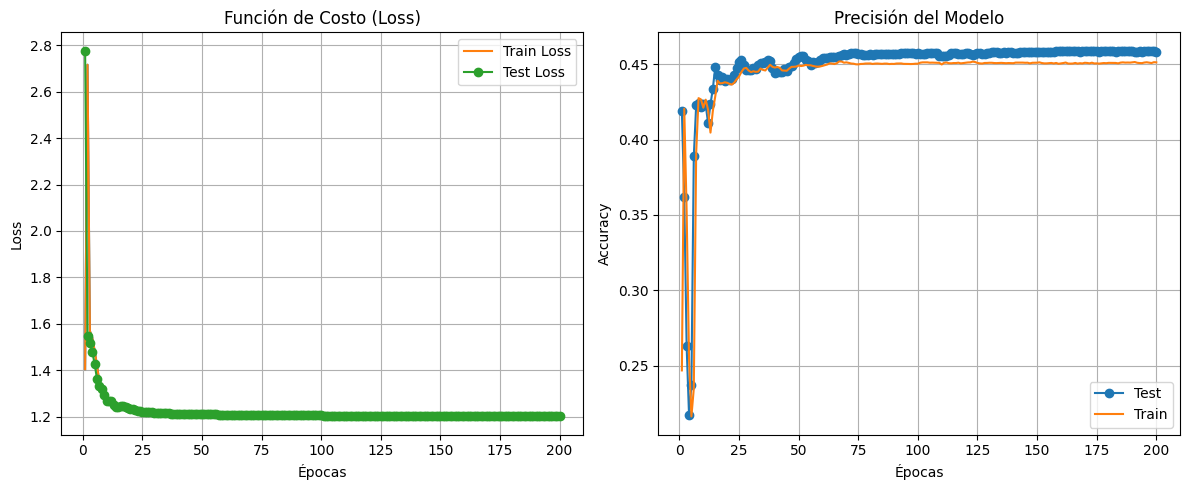

In [29]:
import matplotlib.pyplot as plt

# Visualización de resultados
plt.figure(figsize=(12, 5))

# Gráfica de pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), l)
plt.title('Función de Costo (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.grid(True)

# Gráfica de precisión
plt.subplot(1, 2, 2)
plt.plot(epochs_list, test_accuracies, label='Test', marker='o')
plt.plot(range(1, epochs+1), train_accuracies, label='Train')
plt.title('Precisión del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Gráfica de pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), l, label='Train Loss')
plt.plot(epochs_list, test_losses, label='Test Loss', marker='o')
plt.title('Función de Costo (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Interpretacion del Modelo

Se trabajo con una red neuronal MLP para poder predecir grafos de paginas web de Facebook en funcion a las 4 clases de páginas que se tiene en el dataset, usando el modulo nn de Pytorch que nos permite poder trabajar con mas facilidad con las funciones para el entrenamiento, la arquitectura del modelo y los hiperparametros para asi lograr graficar con cuanta precision y error estamos teniendo en los datos de prueba y de salida.